# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gymnasium as gym
from gymnasium import spaces
import datetime
import my_library as mylib
# import importlib
# importlib.reload(my_library)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None

# Data manipulation

In [2]:
tickers = ['PFE','OXY','JPM','MCD'] # Pfizer, Occidental Petroleum, JPMorgan Chase, McDonald's
# tickers1 = ['PFE ','OXY ','JPM ','MCD '] 
tickers_vol = [ticker+'_VOL' for ticker in tickers]
data = pd.read_csv('others.csv', sep=',')
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
adj_close = data[tickers[2]]
df = pd.DataFrame({'Date': data['Date'], 'log_ret': np.log(adj_close/adj_close.shift(1)).dropna(), tickers_vol[2]: data[tickers_vol[2]]}).dropna().set_index('Date')
sp500 = pd.read_csv('sp500_joined_closes (3).csv', sep=',').dropna(axis=1)
data.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500.columns = new_cols
sp500.drop(tickers[2], axis=1, inplace=True)
sp500.drop(tickers_vol[2], axis=1, inplace=True)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')
col_stocks = [col for col in sp500.columns if not col.endswith('VOL')]
col_vols = [col for col in sp500.columns if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [3]:
sp500_lr = np.log(sp500[col_stocks]/sp500[col_stocks].shift(1))
sp500_lr = sp500_lr.drop(sp500_lr.index[0])
sp500_lr = sp500_lr.drop([col for col in sp500_lr.columns if sp500_lr[col].count() < 3633], axis=1)
df = df.join(sp500[col_vols],how='inner').dropna()
df = df.join(sp500_lr,how='inner').dropna()
df.describe()

log_ret       JPM_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  3638.000000  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean      0.000522  1.964839e+07  3.672072e+06  1.363582e+06  8.361895e+06   
std       0.017505  1.372985e+07  2.911937e+06  1.103023e+06  5.976096e+06   
min      -0.162106  3.220500e+06  7.785960e+05  2.042000e+05  1.067700e+06   
25%      -0.007667  1.116250e+07  2.380937e+06  8.305000e+05  4.614210e+06   
50%       0.000537  1.508550e+07  3.098058e+06  1.113950e+06  6.282250e+06   
75%       0.009055  2.363708e+07  4.108499e+06  1.586875e+06  1.024750e+07   
max       0.165620  2.172942e+08  6.043675e+07  3.248830e+07  7.810838e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean   2.772958e+06  3.756350e+06  4.659924e+07  5.907124e+06  4.438843e+06   
std    2.315021e+06  3.470823e+06  3.549588e+07  2.840392e+06  2.835895e+06   
min    5.281000e+05  5.892000e+05  0.000000e+00  9.862000e+05  8.789000e+05   
25%    1.813925e+06  2.136200e+06  1.889980e+07  4.110050e+06  2.677625e+06   
50%    2.333400e+06  2.906300e+06  3.877410e+07  5.336600e+06  3.640550e+06   
75%    3.150400e+06  4.277000e+06  6.321760e+07  7.026075e+06  5.307400e+06   
max    8.965590e+07  1.087524e+08  3.250584e+08  4.606760e+07  3.669320e+07   

       ...          WST          WDC           WY          WMB          WTW  \
count  ...  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean   ...     0.000799     0.000218     0.000296     0.000441     0.000433   
std    ...     0.017123     0.027057     0.019391     0.024196     0.014200   
min    ...    -0.151802    -0.228719    -0.257132    -0.427912    -0.113525   
25%    ...    -0.007562    -0.013190    -0.009073    -0.009434    -0.005715   
50%    ...     0.000930     0.000462     0.000681     0.000740     0.000695   
75%    ...     0.009358     0.014244     0.009957     0.010422     0.007123   
max    ...     0.135745     0.190144     0.225664     0.295550     0.140681   

              WYNN          XEL          YUM         ZBRA          ZBH  
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000  
mean      0.000211     0.000391     0.000539     0.000641     0.000194  
std       0.028792     0.012314     0.015034     0.022864     0.016214  
min      -0.280172    -0.135726    -0.208654    -0.272411    -0.150757  
25%      -0.013317    -0.005615    -0.006247    -0.009777    -0.007351  
50%      -0.000104     0.000632     0.000839     0.000930     0.000163  
75%       0.013625     0.007141     0.007597     0.011237     0.008326  
max       0.244422     0.106679     0.209032     0.158833     0.144790  

[8 rows x 860 columns]

Performing PCA on AAPL and SP500 stocks

In [4]:
cum_var_exp, PCs, regr_PCs, eig_vecs = mylib.PCA(df['log_ret'], sp500_lr, plot=False)

In [5]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     1275.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:35:13   Log-Likelihood:                 12298.
No. Observations:                3638   AIC:                        -2.457e+04
Df Residuals:                    3627   BIC:                        -2.451e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.151      0.250      -0.000       0.000
PC0            0.0582      0.001     79.310      0.000       0.057       0.060
PC1            0.0388      0.002     18.994      0.000       0.035       0.043
PC2           -0.0539      0.002    -28.657      0.000      -0.058      -0.050
PC3            0.0454      0.003     15.843      0.000       0.040       0.051
PC4           -0.0602      0.003    -21.994      0.000      -0.066      -0.055
PC5           -0.0297      0.003     -8.725      0.000      -0.036      -0.023
PC6            0.0856      0.004     23.052      0.000       0.078       0.093
PC7           -0.0278      0.004     -7.670      0.000      -0.035      -0.021
PC8           -0.0154      0.004     -3.764      0.000      -0.023      -0.007
PC9            0.0378      0.004      8.941      0.000       0.030       0.046
==============================================================================
Omnibus:                      764.063   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21086.259
Skew:                          -0.323   Prob(JB):                         0.00
Kurtosis:                      14.777   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
PCs.columns = PCs.columns.str.replace('AAPL', tickers[2])

In [7]:
Y = PCs[tickers[2]]

In [8]:
[i-1 for i,p in enumerate(regr_PCs.tvalues) if abs(p) > 1.96]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
t_vals = regr_PCs.tvalues.drop('const')

In [10]:
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)

['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9']

In [11]:
X = PCs[list(t_vals.index)]
X

PC0       PC1       PC2       PC3       PC4       PC5  \
Date                                                                     
2010-01-05  0.076524  0.105578 -0.077882 -0.037837 -0.053489 -0.000645   
2010-01-06  0.045054  0.025401 -0.033958  0.021615  0.051311  0.019000   
2010-01-07  0.117785  0.056817 -0.075027 -0.035305 -0.133762 -0.017018   
2010-01-08  0.056748  0.054926  0.033753  0.027469  0.063356  0.061771   
2010-01-11  0.059177 -0.042017 -0.016649 -0.005404 -0.000049 -0.002873   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.114887  0.112102  0.073031 -0.103552 -0.031951  0.052022   
2024-06-13 -0.053811 -0.051931  0.027939 -0.029268 -0.034609  0.002835   
2024-06-14 -0.127373 -0.086609  0.064670 -0.003083 -0.006589 -0.059913   
2024-06-17  0.146830  0.082335  0.007427  0.034286 -0.056457  0.050161   
2024-06-18  0.057679  0.020470 -0.015488  0.022307  0.012157  0.010376   

                 PC6       PC7       PC9  
Date                                      
2010-01-05 -0.027794 -0.019037 -0.004138  
2010-01-06 -0.021755  0.060398  0.007956  
2010-01-07 -0.009059  0.049082 -0.019634  
2010-01-08  0.017532 -0.005797 -0.015553  
2010-01-11  0.007602  0.010218 -0.061137  
...              ...       ...       ...  
2024-06-12  0.082123  0.013208 -0.011441  
2024-06-13 -0.013753 -0.003683  0.013740  
2024-06-14  0.014832 -0.007437  0.071600  
2024-06-17 -0.049372 -0.067660  0.052360  
2024-06-18  0.051110 -0.025395  0.014611  

[3638 rows x 9 columns]

In [12]:
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    JPM   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              1412.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        19:35:32   Log-Likelihood:                          12290.
No. Observations:                3638   AIC:                                 -2.456e+04
Df Residuals:                    3629   BIC:                                 -2.451e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0590      0.001     83.425      0.000       0.058       0.060
PC1            0.0394      0.002     19.293      0.000       0.035       0.043
PC2           -0.0540      0.002    -28.693      0.000      -0.058      -0.050
PC3            0.0448      0.003     15.655      0.000       0.039       0.050
PC4           -0.0597      0.003    -21.830      0.000      -0.065      -0.054
PC5           -0.0303      0.003     -8.894      0.000      -0.037      -0.024
PC6            0.0867      0.004     23.384      0.000       0.079       0.094
PC7           -0.0291      0.004     -8.072      0.000      -0.036      -0.022
PC9            0.0367      0.004      8.682      0.000       0.028       0.045
==============================================================================
Omnibus:                      749.165   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20235.273
Skew:                          -0.301   Prob(JB):                         0.00
Kurtosis:                      14.538   Cond. No.                         7.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
t_vals = regr_PCs.tvalues
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
X = sm.add_constant(X)
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    JPM   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     1551.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:35:50   Log-Likelihood:                 12258.
No. Observations:                3638   AIC:                        -2.450e+04
Df Residuals:                    3629   BIC:                        -2.444e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      1.009      0.313      -0.000       0.000
PC0            0.0582      0.001     82.174      0.000       0.057       0.060
PC1            0.0427      0.002     21.174      0.000       0.039       0.047
PC2           -0.0530      0.002    -27.955      0.000      -0.057      -0.049
PC3            0.0414      0.003     14.495      0.000       0.036       0.047
PC4           -0.0611      0.003    -22.158      0.000      -0.066      -0.056
PC5           -0.0307      0.003     -8.927      0.000      -0.037      -0.024
PC6            0.0891      0.004     23.900      0.000       0.082       0.096
PC9            0.0348      0.004      8.167      0.000       0.026       0.043
==============================================================================
Omnibus:                      725.074   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18626.733
Skew:                          -0.274   Prob(JB):                         0.00
Kurtosis:                      14.072   Cond. No.                         32.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

True

In [15]:
t_vals = regr_PCs.tvalues
t_vals = regr_PCs.tvalues.drop('const')
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

False

In [16]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    JPM   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              1734.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        19:36:05   Log-Likelihood:                          12224.
No. Observations:                3638   AIC:                                 -2.443e+04
Df Residuals:                    3631   BIC:                                 -2.439e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0576      0.001     81.198      0.000       0.056       0.059
PC1            0.0414      0.002     20.408      0.000       0.037       0.045
PC2           -0.0544      0.002    -28.614      0.000      -0.058      -0.051
PC3            0.0417      0.003     14.465      0.000       0.036       0.047
PC4           -0.0558      0.003    -20.648      0.000      -0.061      -0.050
PC5           -0.0317      0.003     -9.145      0.000      -0.038      -0.025
PC6            0.0922      0.004     24.667      0.000       0.085       0.100
==============================================================================
Omnibus:                      701.537   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17604.908
Skew:                          -0.228   Prob(JB):                         0.00
Kurtosis:                      13.767   Cond. No.                         6.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Add the relevant PCs to the df

In [17]:
PCs[tickers[2]]

Date
2010-01-05    0.019185
2010-01-06    0.005479
2010-01-07    0.019616
2010-01-08   -0.002459
2010-01-11   -0.003363
                ...   
2024-06-12   -0.014668
2024-06-13    0.011060
2024-06-14    0.000619
2024-06-17    0.006174
2024-06-18    0.010307
Name: JPM, Length: 3638, dtype: float64

In [18]:
dataframe = pd.DataFrame(PCs[list(t_vals.index)])
dataframe['log_ret'] = df['log_ret']
dataframe

PC0       PC1       PC2       PC3       PC4       PC5  \
Date                                                                     
2010-01-05  0.076524  0.105578 -0.077882 -0.037837 -0.053489 -0.000645   
2010-01-06  0.045054  0.025401 -0.033958  0.021615  0.051311  0.019000   
2010-01-07  0.117785  0.056817 -0.075027 -0.035305 -0.133762 -0.017018   
2010-01-08  0.056748  0.054926  0.033753  0.027469  0.063356  0.061771   
2010-01-11  0.059177 -0.042017 -0.016649 -0.005404 -0.000049 -0.002873   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.114887  0.112102  0.073031 -0.103552 -0.031951  0.052022   
2024-06-13 -0.053811 -0.051931  0.027939 -0.029268 -0.034609  0.002835   
2024-06-14 -0.127373 -0.086609  0.064670 -0.003083 -0.006589 -0.059913   
2024-06-17  0.146830  0.082335  0.007427  0.034286 -0.056457  0.050161   
2024-06-18  0.057679  0.020470 -0.015488  0.022307  0.012157  0.010376   

                 PC6   log_ret  
Date                            
2010-01-05 -0.027794  0.019185  
2010-01-06 -0.021755  0.005479  
2010-01-07 -0.009059  0.019616  
2010-01-08  0.017532 -0.002459  
2010-01-11  0.007602 -0.003363  
...              ...       ...  
2024-06-12  0.082123 -0.014668  
2024-06-13 -0.013753  0.011060  
2024-06-14  0.014832  0.000619  
2024-06-17 -0.049372  0.006174  
2024-06-18  0.051110  0.010307  

[3638 rows x 8 columns]

# Create the environment and agent, training, and backtesting

## Define the environment and agent

In [19]:
class TradingEnv(gym.Env):
    def __init__(self, df, rf):
        super(TradingEnv, self).__init__()

        self.current_step = 0
        self.data = df.iloc[:,df.columns != 'log_ret']
        self.y = df['log_ret']
        self.initial_position = pd.DataFrame({'0': [0], '1': [1]}) # Initial position is 1000 in risk_free asset
        self.position = self.initial_position.copy()
        self.initial_portfolio_value = list([1000])
        self.money = pd.DataFrame(self.initial_portfolio_value[0] * self.position)
        self.rf = rf
        self.pos_sup = 2
        self.pos_inf = -1
        # Define action and observation space
        
        # Only one stock, the rest is in cash
        self.action_space = np.arange(self.pos_inf, self.pos_sup, 0.15).round(2)
        # If two stocks, then self.action_space = spaces.Box(low=np.array([0,0]), high=np.array([1,1]), dtype=np.float32)
        
        # observation_space is a dataframe with historical data
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,df.shape[1]+5), dtype=np.float32)
           
    def step(self, state, action):
        # Execute one time step within the environment
        self.current_step += 1
        self.flag = 0

        # End the episode if we've run out of data
        if self.current_step >= days_train:
            return self.position, 0, True

        # Take the action (<0: short stock, ==0: hold positions, >0: buy stock)
        # action = action[0][0]
        if (action > self.pos_sup) or (action < self.pos_inf):
            reward = - 1000
            self.flag = 1
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
            self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
            pv = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
            new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
            self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)
            observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))
            return new_row_pos, reward, True
        new_port_value = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
        self.portfolio_value.append(new_port_value)
        
        if abs(action - self.position.iloc[self.current_step-1,0]) >= tol:
            new_row_pos = pd.DataFrame([[action, (1 - action)]])
        else:
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
        self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
        new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
        self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)

        if self.flag == 0:
            reward = (self.portfolio_value[self.current_step] - self.portfolio_value[self.current_step-1])/self.portfolio_value[self.current_step-1]
        
        done = self.current_step >= days_train - 1
        
        observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation, reward, done

    def reset(self, noise=True):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        a = (3 * np.random.rand(1) - 1)[0].round(5)
        self.position = pd.DataFrame([a,1-a]).T
        self.portfolio_value = self.initial_portfolio_value.copy()
        self.money = pd.DataFrame(self.portfolio_value[0] * self.position)
        starting_point = np.random.randint(0, self.data.shape[0]-days_train)
        self.df_train = self.data.iloc[starting_point:starting_point+days_train,].copy()
        self.y_train = self.y.iloc[starting_point:starting_point+days_train,].copy()
        if noise:
            for i in range(days_train):
                b = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                self.y_train.iloc[i] += b
                for j in range(len(self.df_train.columns)):
                    c = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                    self.df_train.iloc[i,j] += c

        # The first observation is the returns of the first day, the initial position, and the initial portfolio value
        observation = np.insert(self.df_train.iloc[self.current_step].values.flatten(),0,self.y_train.iloc[self.current_step])
        observation = np.concatenate((observation, [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation

    def render(self, mode='human'):
        # Render the environment to the screen
        if mode == 'human':
            print(f"Current Step: {self.current_step}")
            print(f"Current Position:\n Stock: {self.position.iloc[self.current_step,0]}\n R_f: {self.position.iloc[self.current_step,1]}")
            print(f"env.money:\n Stock: {self.money.iloc[self.current_step,0]}\n R_f: {self.money.iloc[self.current_step,1]}")
            print(f"Portfolio Value: {self.portfolio_value[self.current_step]}")
    
    def train(self, agent, episodes, days):
        self.days_train = days
        for e in range(episodes):
            print(f"Episode: {e+1}/{episodes}")
            state = env.reset()
            # state = np.reshape(state, [1, state_size])
            for time in range(days):
                print(f"Port. Value: {env.portfolio_value[env.current_step]}") 
                action = agent.act(state)*0.15-1
                print(f"condition: {state[0]}")
                print(f"Action: {action}")
                next_state, reward, done = env.step(state,action)
                if agent.flag == 1:
                    agent.reward_pred *= (1+reward)
                    agent.flag = 0
                # next_state = np.reshape(next_state, [1, state_size])
                agent.remember(state, action, reward, next_state, done)
                self.render()
                print(f"Reward: {reward}\n")
                state = next_state
                if done:
                    print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}\n\n\n")
                    break
            if len(agent.memory) > 32:
                agent.replay(32)
    
    def backtest(self, agent, days_test):
        state = self.reset(noise=False)
        total_reward = 1
        for time in range(days_test):
            action = agent.act(state, train=False) * 0.15 - 1
            next_state, reward, done = self.step(state,action)
            total_reward *= (1 + reward)
            state = next_state
            if done:
                break
        annualized_return = (total_reward ** (252 / days_test) - 1) * 100
        print(f"Days: {time}")
        return annualized_return
        





class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=3000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.reward_pred = 1
        self.n_exploit = 0
        self.flag = 0

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='sigmoid'))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, train=True):
        if train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print("EXPLOITATION")
        self.flag = 1
        self.n_exploit += 1
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][int(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Short Training

In [23]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 5
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")


C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/5
Port. Value: 1000
condition: 0.019420481460172584
Action: -0.4
Current Step: 1
Current Position:
 Stock: -0.4
 R_f: 1.4
env.money:
 Stock: -408.00263356982515
 R_f: 1428.009217494388
Portfolio Value: 1020.0065839245628
Reward: 0.020006583924562848

Port. Value: 1020.0065839245628
condition: -0.0182096730283966
Action: 0.7999999999999998
Current Step: 2
Current Position:
 Stock: 0.7999999999999998
 R_f: 0.20000000000000018
env.money:
 Stock: 821.9849295929325
 R_f: 205.49623239823336
Portfolio Value: 1027.481161991166
Reward: 0.007327970411567309

Port. Value: 1027.481161991166
condition: 0.0152140384659065
Action: -0.55
Current Step: 3
Current Position:
 Stock: -0.55
 R_f: 1.55
env.money:
 Stock: -572.0542501853632
 R_f: 1612.1528868860237
Portfolio Value: 1040.0986367006603
Reward: 0.012280005878689704

Port. Value: 1040.0986367006603
condition: 0.028886467026158175
Action: 0.050000000000000044
Current Step: 4
Current Position:
 Stock: 0.050000000000000044
 R_f: 0.95
env.

In [26]:
annualized_return = env.backtest(agent, days_test=252)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

In [27]:
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

Annualized Return on backtesting: 15.18%


## Longer Training

In [28]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")

C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/20
Port. Value: 1000
condition: 0.010183994883037152
Action: 1.85
Current Step: 1
Current Position:
 Stock: 1.85
 R_f: -0.8500000000000001
env.money:
 Stock: 1846.6582861483373
 R_f: -848.4646179600469
Portfolio Value: 998.1936681882904
Reward: -0.0018063318117095832

Port. Value: 998.1936681882904
condition: 0.002176570207812775
Action: 0.34999999999999987
Current Step: 2
Current Position:
 Stock: 0.34999999999999987
 R_f: 0.6500000000000001
env.money:
 Stock: 350.7527626621913
 R_f: 651.3979878012128
Portfolio Value: 1002.150750463404
Reward: 0.003964243013378047

Port. Value: 1002.150750463404
condition: 0.01620678057637174
Action: -1.0
Current Step: 3
Current Position:
 Stock: -1.0
 R_f: 2.0
env.money:
 Stock: -1007.9328277745996
 R_f: 2015.8656555491991
Portfolio Value: 1007.9328277745996
Reward: 0.005769668194652172

Port. Value: 1007.9328277745996
condition: 0.008495447598298395
Action: -1.0
Current Step: 4
Current Position:
 Stock: -1.0
 R_f: 2.0
env.money:
 Stock: -

In [29]:
random.seed(123456789)
annualized_return = env.backtest(agent, days_test=252)
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━

In [30]:
# Serialize the classifier to a file named 'agent.pkl'
with open('agent_jpm.pkl', 'wb') as file:
    pickle.dump(agent, file)

# To later deserialize the classifier from the file
# with open('agent_jpm.pkl', 'rb') as file:
#     loaded_agent = pickle.load(file)

## Test with new data

In [31]:
# Data manipulation
data_NEW = pd.read_csv('others_NEW.csv', sep=',')
data_NEW['Date'] = pd.to_datetime(data_NEW['Date'],format='%Y-%m-%d')
adj_close_NEW = data_NEW[tickers[2]]
df1 = pd.DataFrame({'Date': data_NEW['Date'], 'log_ret': np.log(adj_close_NEW/adj_close_NEW.shift(1)).dropna(), tickers_vol[2]: data_NEW[tickers_vol[2]]}).dropna().set_index('Date')
sp500_NEW = pd.read_csv('sp500_joined_closes_NEW.csv', sep=',').dropna(axis=1)
sp500_NEW.drop('JPM ', axis=1, inplace=True)
sp500_NEW.drop('JPM _VOL', axis=1, inplace=True)
data_NEW.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500_NEW.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500_NEW.columns = new_cols
sp500_NEW['Date'] = pd.to_datetime(sp500_NEW['Date'])
sp500_NEW = sp500_NEW.set_index('Date')
sp500_NEW = sp500_NEW[[col for col in sp500.columns]]
new_cols = sp500_NEW.columns
col_stocks = [col for col in new_cols if not col.endswith('VOL')]
col_vols = [col for col in new_cols if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [32]:
sp500_lr_NEW = np.log(sp500_NEW[col_stocks]/sp500_NEW[col_stocks].shift(1))
sp500_lr_NEW = sp500_lr_NEW.drop(sp500_lr_NEW.index[0])
# sp500_lr_NEW = sp500_lr_NEW.drop([col for col in sp500_lr_NEW.columns if sp500_lr_NEW[col].count() < 3633], axis=1)
df1 = df1.join(sp500_NEW[col_vols],how='inner').dropna()
df1 = df1.join(sp500_lr_NEW,how='inner').dropna()
df1.describe()

log_ret       JPM_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  37.000000  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean    0.001382  9.606014e+06  4.808686e+06  1.102470e+06  7.180724e+06   
std     0.015619  3.472308e+06  5.087143e+06  4.212829e+05  3.317233e+06   
min    -0.043338  5.540200e+06  1.230800e+06  5.398000e+05  2.017800e+06   
25%    -0.006571  7.663200e+06  2.884900e+06  8.747000e+05  4.970800e+06   
50%     0.000818  8.707000e+06  3.381000e+06  1.025900e+06  6.356600e+06   
75%     0.015099  1.071970e+07  4.598100e+06  1.190100e+06  8.611600e+06   
max     0.027529  2.097250e+07  3.274890e+07  2.721300e+06  1.945270e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean   3.404114e+06  2.619322e+06  5.564599e+07  8.377762e+06  2.296111e+06   
std    2.325463e+06  1.055446e+06  1.849204e+07  4.929767e+06  1.388765e+06   
min    1.629200e+06  1.272600e+06  2.698090e+07  3.243100e+06  1.040000e+06   
25%    2.283500e+06  2.075400e+06  4.220270e+07  5.224700e+06  1.515000e+06   
50%    2.682700e+06  2.368400e+06  5.043670e+07  7.055500e+06  1.898600e+06   
75%    3.640500e+06  3.054500e+06  6.185710e+07  9.712200e+06  2.212000e+06   
max    1.490550e+07  6.614100e+06  1.143068e+08  2.844530e+07  7.552800e+06   

       ...        WST        WDC         WY        WMB        WTW       WYNN  \
count  ...  37.000000  37.000000  37.000000  37.000000  37.000000  37.000000   
mean   ...  -0.002862  -0.005789   0.001550   0.000455   0.001581  -0.005127   
std    ...   0.031343   0.033936   0.017124   0.014376   0.012160   0.017542   
min    ...  -0.155438  -0.102300  -0.029672  -0.036737  -0.031149  -0.050899   
25%    ...  -0.008031  -0.019890  -0.011173  -0.007505  -0.004725  -0.015403   
50%    ...   0.000247  -0.003337   0.000000   0.000466   0.002202  -0.005169   
75%    ...   0.011730   0.015123   0.013181   0.007239   0.008741   0.004030   
max    ...   0.038771   0.059451   0.048825   0.037830   0.038933   0.036576   

             XEL        YUM       ZBRA        ZBH  
count  37.000000  37.000000  37.000000  37.000000  
mean    0.002930   0.000684   0.003053   0.000827  
std     0.012876   0.011661   0.019387   0.014313  
min    -0.029899  -0.026390  -0.061022  -0.034919  
25%    -0.003605  -0.007918  -0.006052  -0.005720  
50%     0.002284   0.001043   0.004828   0.001383  
75%     0.010769   0.008022   0.013832   0.005858  
max     0.027938   0.026133   0.038148   0.032862  

[8 rows x 860 columns]

In [33]:
eig_vecs.shape

(429, 429)

In [34]:
sp500_lr_NEW.shape

(37, 429)

In [35]:
# Applying PCA trasformation on new data
PCs = mylib.apply_PCA(df1['log_ret'], sp500_lr_NEW, eig_vecs)

# Add the relevant PCs to the df
dataframe1 = pd.DataFrame(PCs[['PC0','PC1','PC2','PC3','PC4','PC5','PC6']])
dataframe1['log_ret'] = df1['log_ret']
dataframe1

PC0       PC1       PC2       PC3       PC4       PC5  \
Date                                                                     
2024-06-21  0.032389  0.009050  0.042600 -0.010381 -0.028809 -0.017352   
2024-06-24  0.108199 -0.053482 -0.163994  0.066596  0.034339  0.004650   
2024-06-25 -0.167803  0.067146  0.050953 -0.017804  0.063336 -0.086584   
2024-06-26 -0.066544 -0.002562  0.024425 -0.032298 -0.006819  0.021957   
2024-06-27  0.007567 -0.020820  0.004765 -0.058945  0.006573 -0.026365   
2024-06-28  0.023432  0.045213 -0.059256 -0.009197 -0.018571  0.014548   
2024-07-01 -0.166702  0.005921 -0.010640  0.046725  0.021416 -0.050968   
2024-07-02  0.084735  0.011884  0.015512 -0.025675 -0.001832  0.008751   
2024-07-03  0.005667  0.034342  0.021596 -0.021306  0.067934  0.040295   
2024-07-05 -0.027294 -0.081881  0.119575 -0.019860 -0.012662 -0.031664   
2024-07-08  0.043855  0.045280 -0.002981 -0.013881 -0.002668  0.052733   
2024-07-09 -0.032798 -0.017374 -0.047851  0.000654 -0.041409 -0.038042   
2024-07-10  0.196795  0.016269  0.011826  0.020156  0.021866  0.059216   
2024-07-11  0.245504 -0.070810 -0.070952 -0.022979 -0.033013  0.067637   
2024-07-12  0.157472  0.000510  0.043226 -0.020842  0.009561  0.040751   
2024-07-15  0.021481  0.105287 -0.061946  0.042729 -0.008563  0.012958   
2024-07-16  0.356531  0.036310 -0.004584 -0.039040 -0.064202  0.063977   
2024-07-17 -0.063443 -0.229952 -0.181525  0.125859 -0.077030 -0.091431   
2024-07-18 -0.180625 -0.029309 -0.064431 -0.008077  0.034535  0.047661   
2024-07-19 -0.145663 -0.035474  0.004567 -0.044060 -0.029410 -0.049121   
2024-07-22  0.171884  0.044698  0.104572 -0.074220  0.005341  0.042666   
2024-07-23 -0.075014  0.009183 -0.015734 -0.017850 -0.063622 -0.044719   
2024-07-24 -0.227756 -0.222114 -0.067145  0.163956 -0.006702 -0.092557   
2024-07-25  0.019505  0.018448 -0.096416  0.112286 -0.039710  0.072024   
2024-07-26  0.289405  0.004416 -0.032720 -0.015802 -0.029108  0.090156   
2024-07-29  0.030575 -0.040103  0.051752 -0.059203 -0.010244 -0.025452   
2024-07-30  0.087811 -0.046767 -0.079350  0.022340 -0.074760 -0.051697   
2024-07-31  0.089577  0.119248  0.126191 -0.047062  0.148826  0.091303   
2024-08-01 -0.211804 -0.388904  0.010632  0.065091 -0.059187 -0.083387   
2024-08-02 -0.373246 -0.343771  0.039488  0.066086 -0.107758 -0.073328   
2024-08-05 -0.504278  0.022177 -0.016354  0.034825 -0.012128  0.050275   
2024-08-06  0.194517  0.013640  0.003978 -0.103360 -0.015901 -0.012153   
2024-08-07 -0.166627 -0.085123 -0.082479  0.045179  0.018297 -0.036761   
2024-08-08  0.375706  0.178732  0.088761 -0.054288  0.089684 -0.003524   
2024-08-09  0.032624 -0.007530 -0.013040 -0.019234 -0.014320 -0.014183   
2024-08-12 -0.095150 -0.001763  0.002669 -0.002474  0.081461 -0.029907   
2024-08-13  0.235531  0.057860  0.105917 -0.066388 -0.026929  0.030730   

                 PC6   log_ret  
Date                            
2024-06-21 -0.022612 -0.012001  
2024-06-24 -0.023312  0.013058  
2024-06-25  0.019734 -0.004081  
2024-06-26  0.004329 -0.003236  
2024-06-27  0.027443  0.008775  
2024-06-28  0.039010  0.015395  
2024-07-01  0.059881  0.015649  
2024-07-02  0.032338  0.016318  
2024-07-03  0.021154 -0.000671  
2024-07-05 -0.017232 -0.013339  
2024-07-08  0.001793  0.001854  
2024-07-09  0.047449  0.011919  
2024-07-10  0.024718  0.000818  
2024-07-11  0.010688 -0.001686  
2024-07-12 -0.015648 -0.012173  
2024-07-15  0.059247  0.024628  
2024-07-16 -0.073995  0.016853  
2024-07-17 -0.035386  0.015099  
2024-07-18  0.015727 -0.032286  
2024-07-19 -0.017973 -0.000953  
2024-07-22  0.067462  0.002381  
2024-07-23  0.052481  0.000238  
2024-07-24  0.032858 -0.008307  
2024-07-25  0.018988  0.000383  
2024-07-26 -0.027559  0.016964  
2024-07-29 -0.035548 -0.006571  
2024-07-30 -0.015316  0.020374  
2024-07-31  0.018463 -0.011169  
2024-08-01  0.020468 -0.023007  
2024-08-02 -0.045830 -0.043338  
2024-08-05 -0.012506 -0.021522  
2024-08-06  0.010095  0.027529  
2024-08-

In [36]:
with open('agent_jpm.pkl', 'rb') as file:
    loaded_agent = pickle.load(file)

rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 36

env1 = TradingEnv(dataframe1, rf)
agent1 = loaded_agent

In [39]:
random.seed(123456789)
annualized_return1 = env1.backtest(agent1, days_test=dataframe1.shape[0])
print(f"Annualized Return on NEW DATA: {annualized_return1:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

### Perform multiple tests

In [40]:
n_tests = 200
annualized_returns = list([])
avg_return = 0
for i in range(n_tests):
    annualized_returns.append(env1.backtest(agent1, days_test=dataframe1.shape[0]))
    avg_return += annualized_returns[i]
avg_return /= n_tests
std_return = np.std(annualized_returns)
print(f"Average Annualized Return on NEW DATA: {avg_return:.2f}%")
print(f"Standard Deviation of Annualized Returns on NEW DATA: {std_return:.2f}%")
print(f"Coefficient of Variation of Annualized Returns on NEW DATA: {std_return/avg_return:.2f}")

# Average Annualized Return on NEW DATA: -0.14%
# Standard Deviation of Annualized Returns on NEW DATA: 6.92%
# Coefficient of Variation of Annualized Returns on NEW DATA: -50.65

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

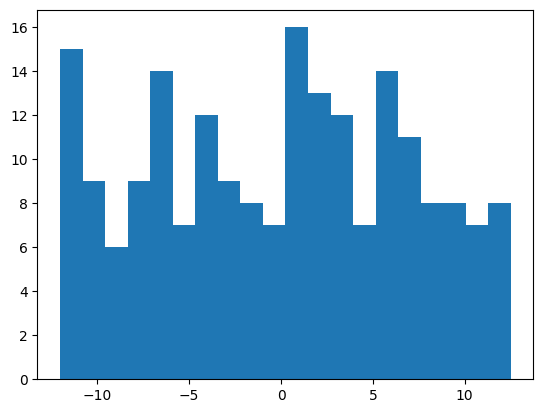

In [41]:
plt.hist(annualized_returns, bins=20)
plt.show()

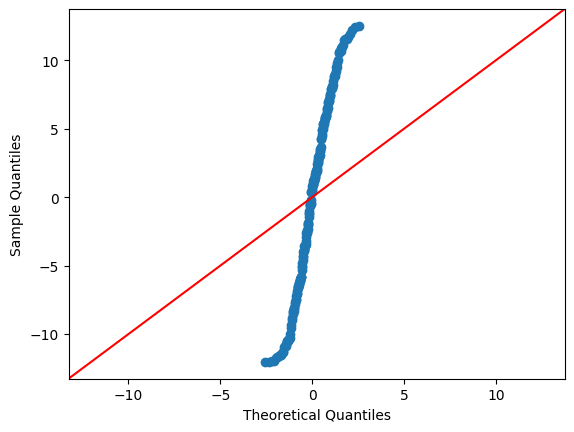

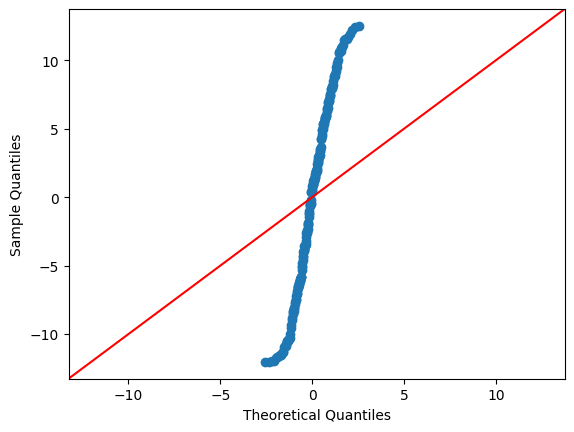

In [42]:
sm.qqplot(np.array(annualized_returns), line ='45')

((array([3.46573590e-03, 8.43263005e-03, 1.34784950e-02, 1.85499498e-02,
         2.36472554e-02, 2.87706768e-02, 3.39204828e-02, 3.90969467e-02,
         4.43003458e-02, 4.95309620e-02, 5.47890815e-02, 6.00749950e-02,
         6.53889979e-02, 7.07313904e-02, 7.61024774e-02, 8.15025688e-02,
         8.69319796e-02, 9.23910299e-02, 9.78800451e-02, 1.03399356e-01,
         1.08949299e-01, 1.14530215e-01, 1.20142454e-01, 1.25786367e-01,
         1.31462315e-01, 1.37170663e-01, 1.42911784e-01, 1.48686055e-01,
         1.54493863e-01, 1.60335598e-01, 1.66211659e-01, 1.72122454e-01,
         1.78068393e-01, 1.84049898e-01, 1.90067397e-01, 1.96121326e-01,
         2.02212127e-01, 2.08340255e-01, 2.14506168e-01, 2.20710335e-01,
         2.26953235e-01, 2.33235353e-01, 2.39557186e-01, 2.45919238e-01,
         2.52322026e-01, 2.58766074e-01, 2.65251917e-01, 2.71780101e-01,
         2.78351183e-01, 2.84965729e-01, 2.91624319e-01, 2.98327543e-01,
         3.05076004e-01, 3.11870316e-01, 3.18711107

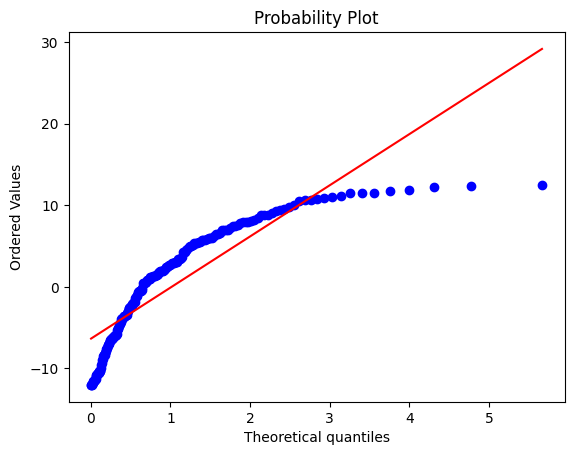

In [43]:
import scipy
scipy.stats.probplot(annualized_returns, dist="expon", plot=plt)